# KNN Model Implementation (Baseline)

In [3]:
import pandas as pd
import numpy as np
from sklearn import set_config
import seaborn as sns
import matplotlib.pyplot as plt
set_config(display="diagram")
pd.set_option('display.max_columns', None)

In [4]:
#reading data
df_acc=pd.read_csv('accident_data.csv')
df_veh=pd.read_csv('vehicle_data.csv', encoding='latin1')

In [5]:
# merging the data
df=pd.merge(df_veh, df_acc, on='Accident_Index')

In [6]:
#Data Missing or out of range->nan
def missing_values_change(val):
    if str(val)=="Unclassified" or str(val)=='None' or str(val)=="Data missing or out of range" or str(val)=="Unallocated":
        return np.nan
    else:
        return val
for col in df.columns:
    df[col] = df[col].apply(lambda x:missing_values_change(x))

In [7]:
#checking missing values percentage
df.isnull().mean()*100

Accident_Index                                  0.000000
Age_Band_of_Driver                              7.645586
Age_of_Vehicle                                 13.259379
Driver_Home_Area_Type                          14.828084
Driver_IMD_Decile                              21.006092
Engine_Capacity_.CC.                            8.396024
Hit_Object_in_Carriageway                      96.004242
Hit_Object_off_Carriageway                     91.369040
Journey_Purpose_of_Driver                       1.573638
Junction_Location                               0.249118
make                                            0.000000
model                                          16.475717
Propulsion_Code                                 6.908098
Sex_of_Driver                                   0.000000
Skidding_and_Overturning                       86.744321
Towing_and_Articulation                         0.001850
Vehicle_Leaving_Carriageway                     0.003083
Vehicle_Location.Restricted_Lan

In [8]:
#identifying columns that contain upto 5 percent missing data 
cols_upto_5=[var for var in df.columns if df[var].isnull().mean() < 0.05 and 
            df[var].isnull().mean() > 0]

cols_upto_5
print(np.shape(cols_upto_5))

(23,)


In [9]:
new_df=df[cols_upto_5].dropna()

In [10]:
new_df.shape

(149593, 23)

In [11]:
df2=df.merge(new_df)

In [12]:
df2.shape

(157061, 55)

<AxesSubplot: >

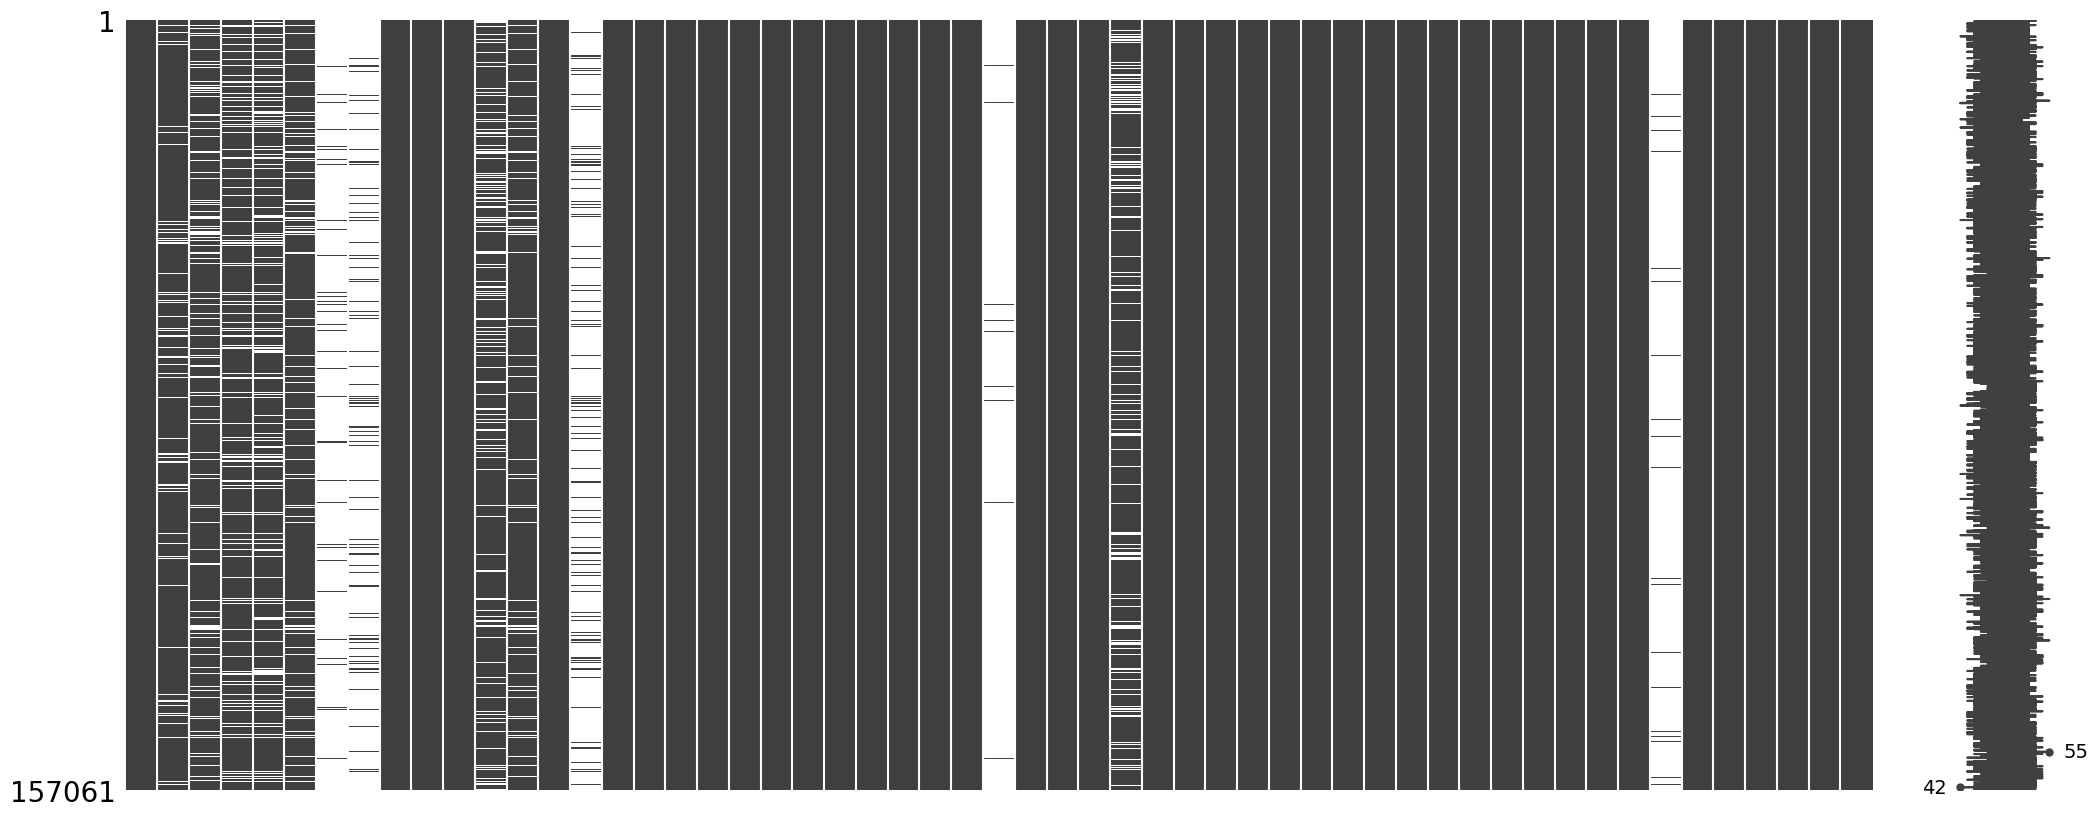

In [13]:
import missingno as msno
msno.matrix(df2)

In [14]:
#identifying columns that contain more than 75 percent missing data 
cols_morethan_75=[var for var in df2.columns if df2[var].isnull().mean() >  0.75]
print(cols_morethan_75)

['Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'Skidding_and_Overturning', 'Carriageway_Hazards', 'Special_Conditions_at_Site']


<AxesSubplot: >

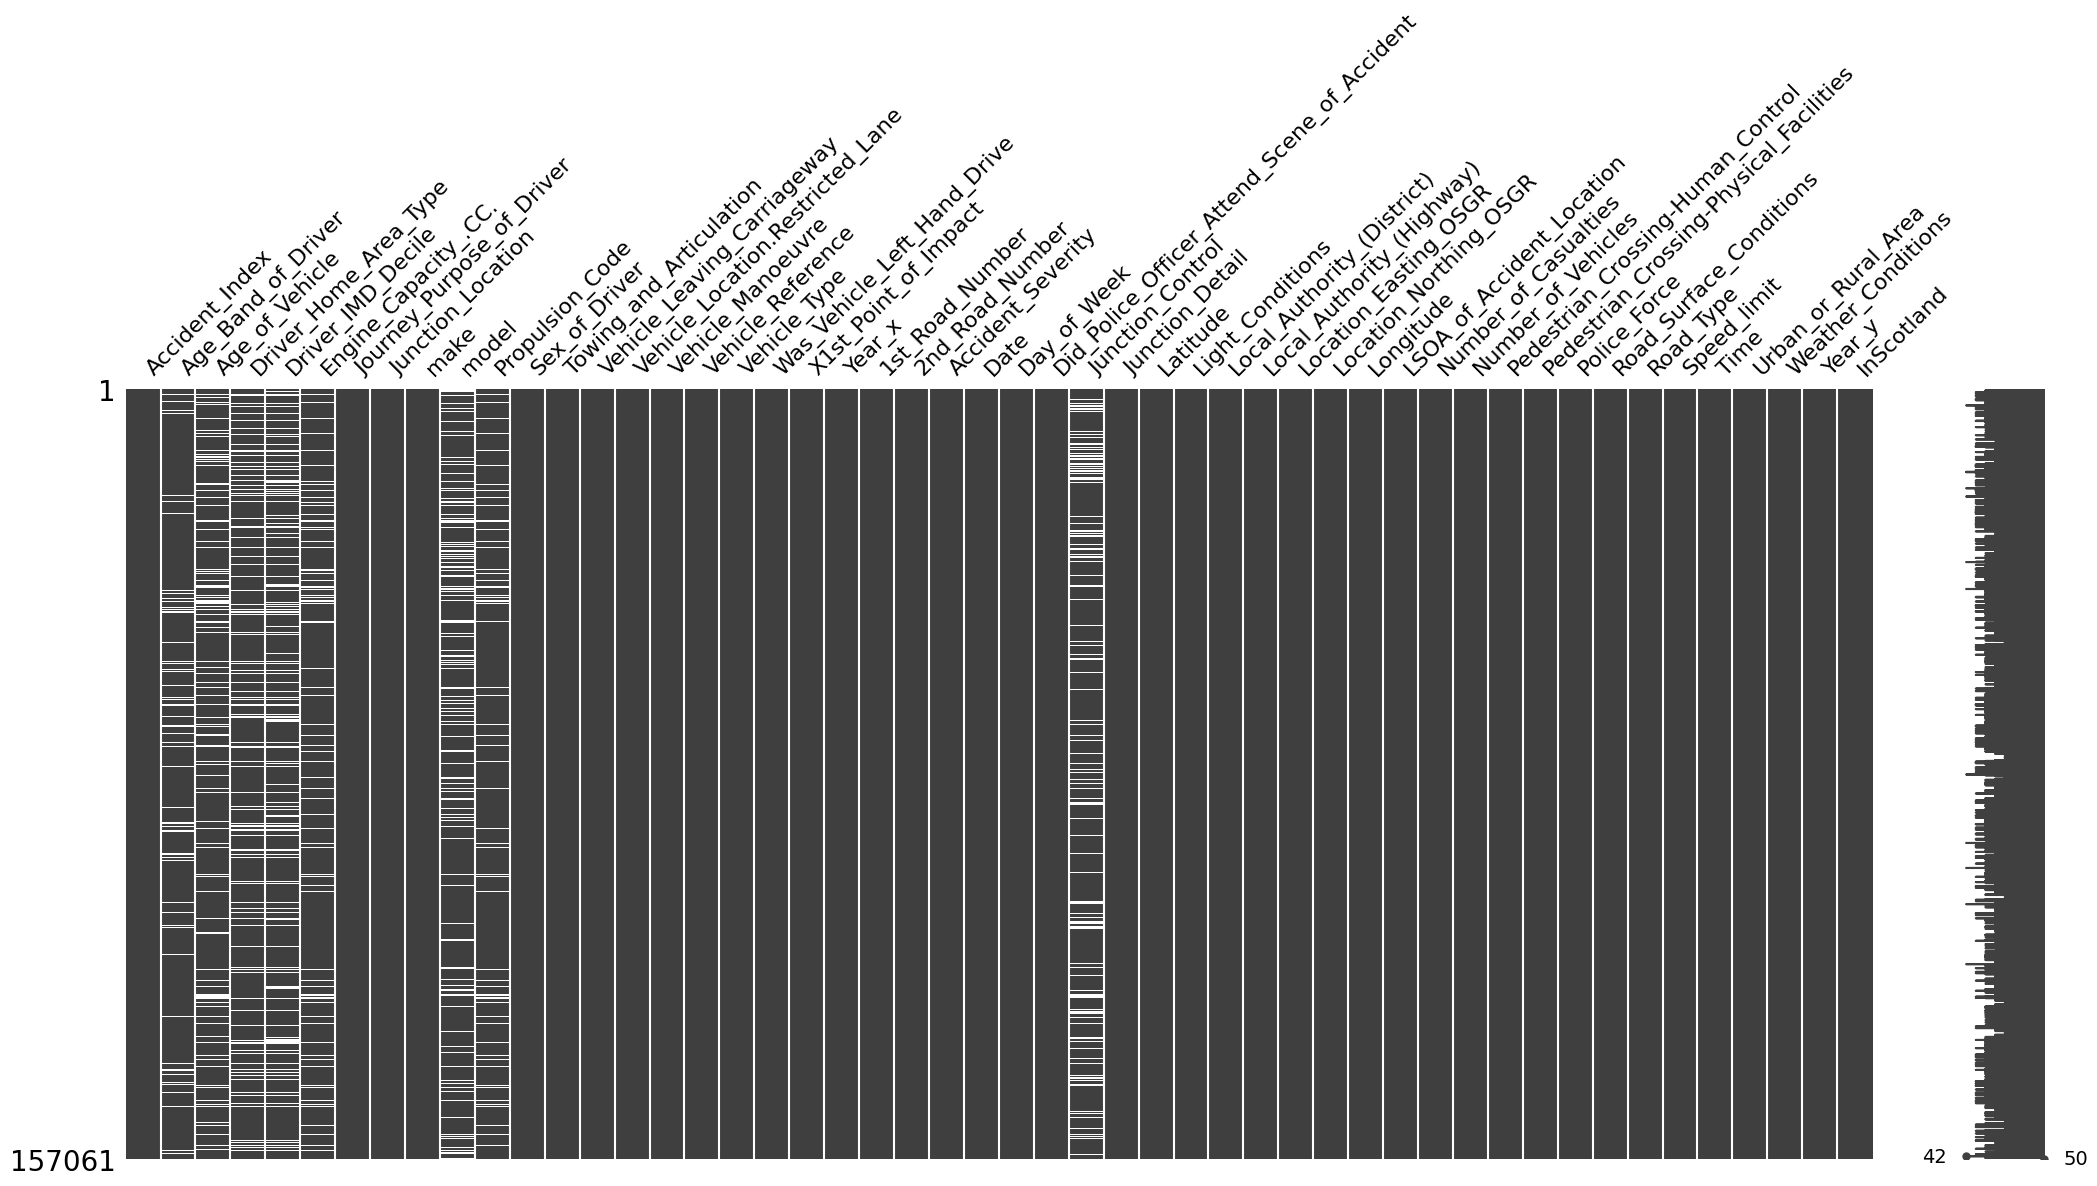

In [15]:
df2=df2.drop(df2[cols_morethan_75], axis =1)
        
msno.matrix(df2)

In [16]:
#replacing misspelled values
df2['Junction_Control'] = df2['Junction_Control'].replace(to_replace='Auto traffic sigl', value='Auto traffic signal')

In [17]:
#splitting Time into Hours
df2['Hour']=df2['Time'].str.split(':').str[0]

#splitting Date into days and months
df2['Day']=df2['Date'].str.split('-').str[0]
df2['Month']=df2['Date'].str.split('-').str[1]

#splitting Age_Band_of_Driver
df2['Age_of_Driver']=df2['Age_Band_of_Driver'].str.split('-').str[1]

In [18]:
#converting Hour, Day, Month column type to integer
df2['Hour']=df2['Hour'].astype(int)
df2['Day']=df2['Day'].astype(int)
df2['Month']=df2['Month'].astype(int)
df2['Age_of_Driver']=df2['Age_of_Driver'].astype(float)

#drop the Time, Minute and Date columns
df2 = df2.drop('Time', axis=1)
df2 = df2.drop('Date', axis=1)
df2 = df2.drop('Age_Band_of_Driver', axis=1)

#drop columns that contain useless or extra information
df2 = df2.drop('Location_Easting_OSGR', axis=1)
df2 = df2.drop('Location_Northing_OSGR', axis=1)
df2 = df2.drop('Accident_Index', axis=1)

df3=df2.copy()


In [19]:
#identify categorical and numeric features
cat_cols=df3.select_dtypes('object').columns
num_cols=df3.select_dtypes('number').columns

In [20]:
#drop accident_severity bcuz it will be one-hot encoded and the rest of the cat_cols will be label encoded
cat_cols=cat_cols.drop('Accident_Severity')

In [21]:
#identify columns containing more than 5 percent missing data
cat_cols_morethan_5=[var for var in df3.columns if df3[var].isnull().mean() > 0.05 and df3[var].dtype=="object" ]
num_cols_morethan_5=[var for var in df3.columns if df3[var].isnull().mean() > 0.05 and df3[var].dtype=="int" or df3[var].dtype=="float"]

display(cat_cols_morethan_5)
display(num_cols_morethan_5)


['Driver_Home_Area_Type', 'model', 'Propulsion_Code', 'Junction_Control']

['Age_of_Vehicle',
 'Driver_IMD_Decile',
 'Engine_Capacity_.CC.',
 'Vehicle_Location.Restricted_Lane',
 '2nd_Road_Number',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'Latitude',
 'Longitude',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Age_of_Driver']

In [22]:
#create a column transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

ct = ColumnTransformer([
    ('Cat_Imputer', SimpleImputer(strategy='constant', fill_value='Data Missing'),cat_cols_morethan_5),
    ('Num_Imputer', SimpleImputer(strategy='mean'),num_cols_morethan_5),
    ('OrdinalEncoder', OrdinalEncoder(categories=[['Slight','Serious','Fatal']]),['Accident_Severity']),])

In [23]:
#tranform
arr=ct.fit_transform(df3)
#convert to dataframe
arr_df=pd.DataFrame(arr)
print(arr_df[15].values[209])
#rename the transformed labels back to their original labels
arr_df=arr_df.rename(columns={0:'Driver_Home_Area_Type', 1:'model', 2:'Propulsion_Code', 3:'Junction_Control', 
                              4:'Age_of_Vehicle', 5:'Driver_IMD_Decile', 6:'Engine_Capacity_.CC.',
                              7:'Vehicle_Location.Restricted_Lane', 8: '2nd_Road_Number', 9:'Did_Police_Officer_Attend_Scene_of_Accident', 10:'Latitude',
                              11:'Longitude', 12:'Pedestrian_Crossing-Human_Control', 13:'Pedestrian_Crossing-Physical_Facilities', 
                              14:'Age_of_Driver',15:'Accident_Severity'})

0.0


In [24]:
#replace the raw dataframes with the transformed dataframes
df3['Driver_Home_Area_Type']=arr_df['Driver_Home_Area_Type']
df3['model']=arr_df['model']
df3['Junction_Control']=arr_df['Junction_Control']
df3['Age_of_Vehicle']=arr_df['Age_of_Vehicle']
df3['Driver_IMD_Decile']=arr_df['Driver_IMD_Decile']
df3['Engine_Capacity_.CC.']=arr_df['Engine_Capacity_.CC.']
df3['Vehicle_Location.Restricted_Lane']=arr_df['Vehicle_Location.Restricted_Lane']
df3['2nd_Road_Number']=arr_df['2nd_Road_Number']
df3['Did_Police_Officer_Attend_Scene_of_Accident']=arr_df['Did_Police_Officer_Attend_Scene_of_Accident']
df3['Longitude']=arr_df['Longitude']
df3['Pedestrian_Crossing-Human_Control']=arr_df['Pedestrian_Crossing-Human_Control']
df3['Pedestrian_Crossing-Physical_Facilities']=arr_df['Pedestrian_Crossing-Physical_Facilities']
df3['Age_of_Driver']=arr_df['Age_of_Driver']
df3['Accident_Severity']=arr_df['Accident_Severity']

df3['Accident_Severity']=df3['Accident_Severity'].astype(int)
df3.shape

(157061, 48)

<AxesSubplot: >

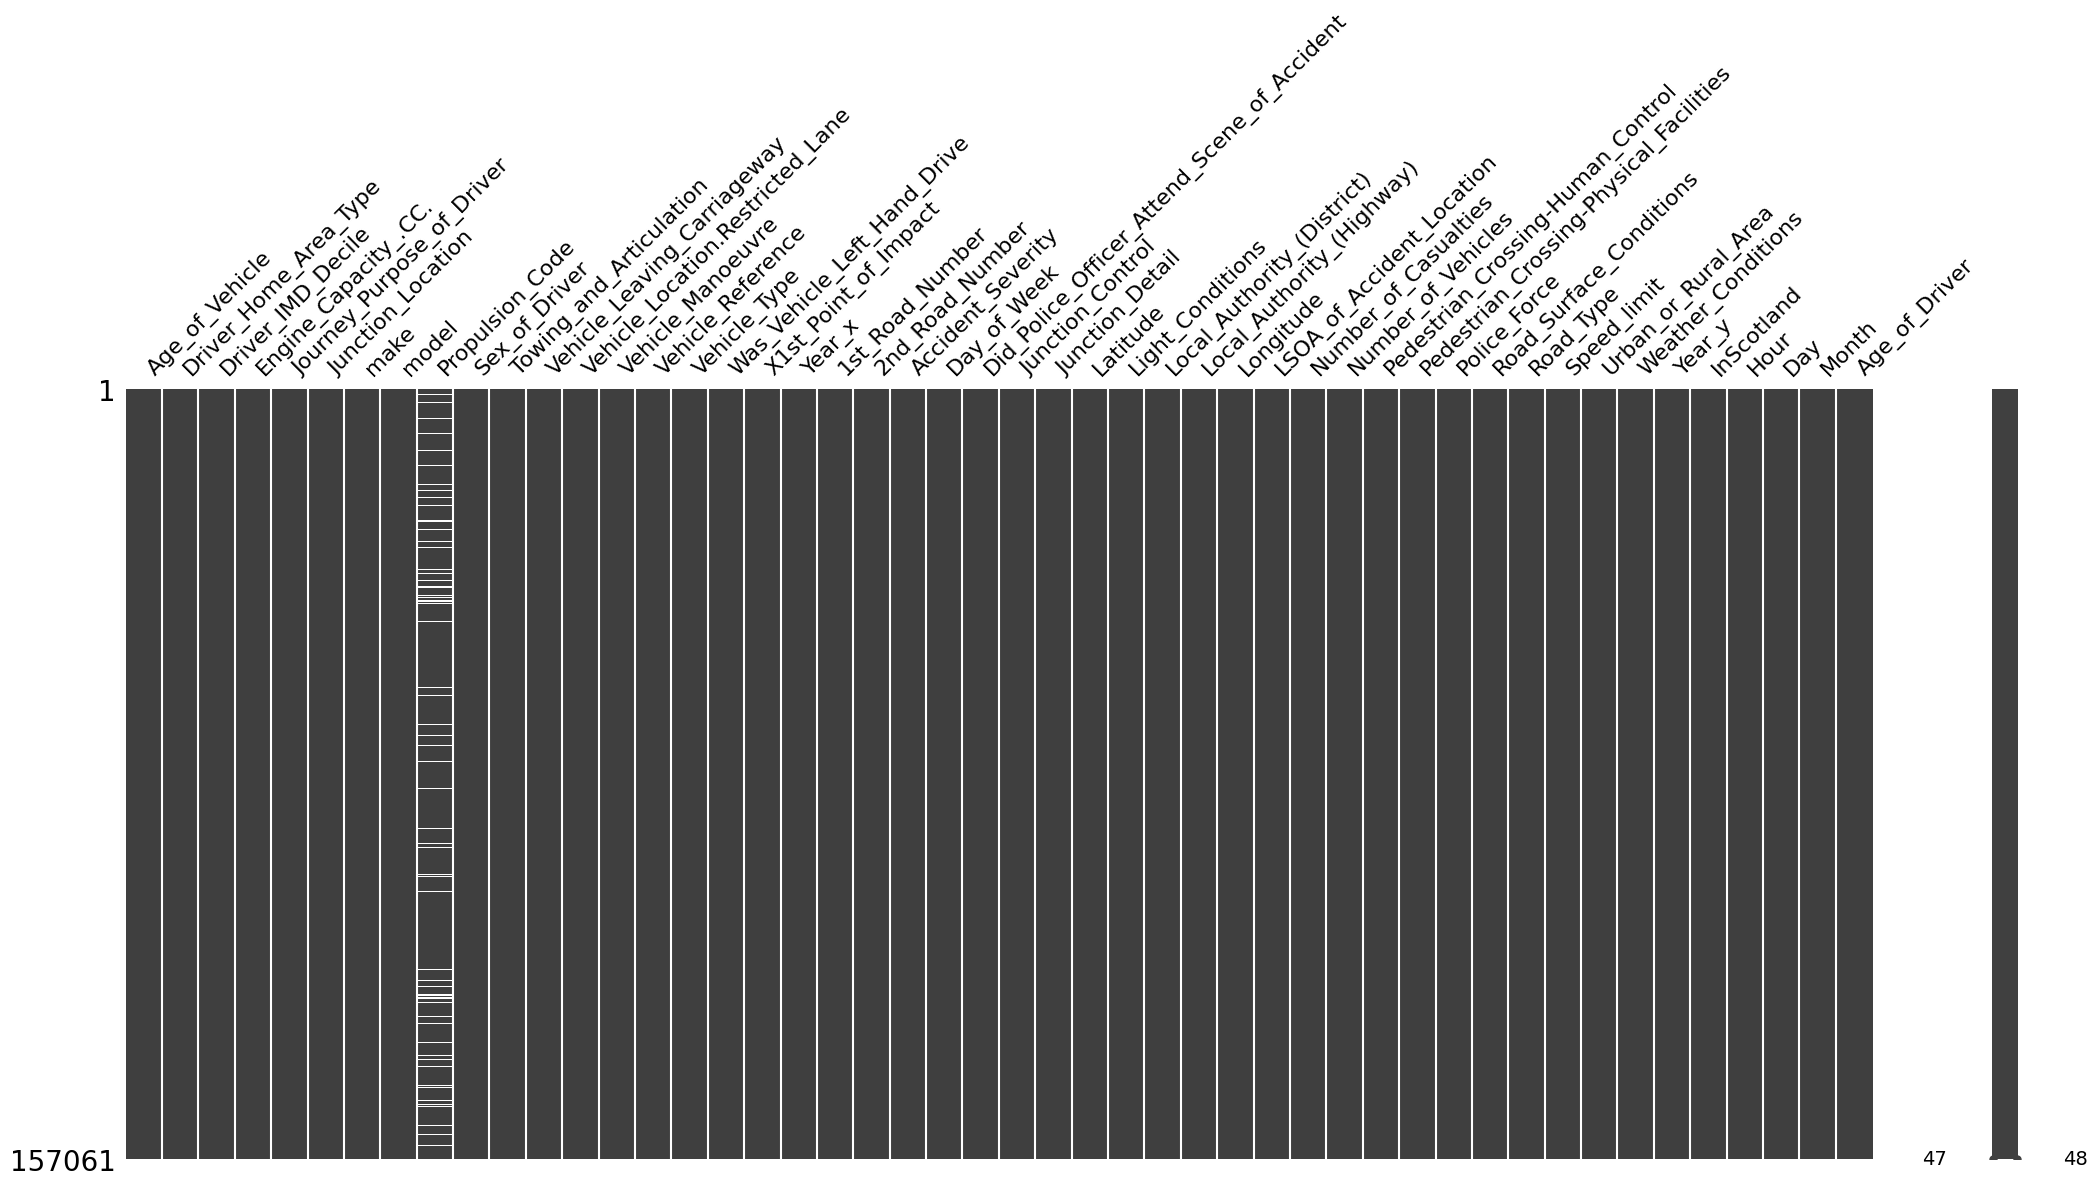

In [25]:
import missingno as msno

msno.matrix(df3)

In [28]:
#label encoder on cat_cols
label_encoder=LabelEncoder()
for cat_cols in cat_cols:
    df3[cat_cols]= label_encoder.fit_transform(df3[cat_cols])

df3.sample(10)

,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year_x,1st_Road_Number,2nd_Road_Number,Accident_Severity,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Urban_or_Rural_Area,Weather_Conditions,Year_y,InScotland,Hour,Day,Month,Age_of_Driver
33229,6.346661,2,6.0,2213.667729,1,1,312,8873,7,1,3,0,0.0,2,1,5,0,3,2006,6166,6326.0,0,0,2.0,1,0,53.074554,4,139,75,-0.80971,14908,1,1,0.0,5.0,22,0,3,30,1,1,2006,0,16,13,10,65.0
83107,3.0,3,8.0,1124.0,2,8,223,433,5,1,3,1,0.0,4,1,2,0,2,2008,0,0.0,1,3,1.0,4,3,51.604471,3,177,36,0.737274,12427,4,1,0.0,0.0,9,0,3,60,0,1,2008,0,4,17,8,20.0
95293,6.0,3,7.0,1390.0,2,7,312,10570,5,0,3,0,0.0,13,1,2,0,4,2009,218,0.0,1,0,1.0,3,8,51.431220,1,131,66,-0.193601,2738,1,2,0.0,0.0,17,0,3,30,1,1,2009,0,20,18,9,43.281856
103677,6.0,2,2.0,1995.0,2,0,29,1060,3,1,3,0,0.0,13,1,2,0,3,2009,618,631.0,0,2,1.0,1,0,53.406565,4,179,88,-1.333585,6125,1,2,0.0,5.0,23,0,0,40,1,1,2009,0,11,7,2,25.0
106898,10.0,3,1.0,1598.0,2,1,306,3250,5,1,3,0,0.0,3,1,2,0,2,2009,0,0.0,1,6,1.0,3,8,52.507932,4,63,32,-2.073783,7188,1,1,0.0,0.0,29,0,1,30,1,1,2009,0,14,15,7,65.0
147301,10.0,0,5.279158,1598.0,2,0,62,10054,5,2,3,0,0.0,9,2,2,0,0,2010,0,0.0,1,4,1.0,3,8,53.545187,1,260,121,-2.663694,5005,1,2,0.0,0.0,10,4,0,30,1,0,2010,0,19,11,11,45.0
94725,19.0,3,3.0,1997.0,2,0,194,310,5,0,3,0,0.0,3,1,2,0,0,2009,0,0.0,0,2,1.0,3,8,51.483331,4,105,50,-0.381225,2039,1,2,0.0,1.0,17,0,3,30,1,1,2009,0,14,21,3,45.0
42383,5.0,3,3.0,8268.0,1,7,72,6141,3,1,3,0,2.0,3,2,1,0,2,2007,13,1268.0,0,3,1.0,3,8,51.512787,4,237,114,0.000154,3305,1,2,0.0,0.0,17,0,3,30,1,1,2007,0,17,25,3,55.0
61466,13.0,3,5.0,8650.0,1,4,63,6141,3,1,3,0,0.0,3,1,1,0,2,2007,4,3290.0,0,6,2.0,1,6,51.454715,4,266,125,-0.937954,9952,1,2,0.0,0.0,27,0,2,40,1,1,2007,0,11,11,7,55.0
100838,5.0,0,5.279158,1599.0,2,5,94,12223,5,0,3,0,0.0,13,2,2,0,4,2009,626,6171.0,0,1,1.0,3,8,53.399998,4,218,103,-2.126604,4610,1,2,0.0,0.0,10,0,3,30,1,1,2009,0,14,4,5,55.0


In [29]:
#create a copy of df3
df4=df3.copy()

In [30]:
#identify dependent and independent variables
X=df4.drop('Accident_Severity', axis=1)
y=df4.Accident_Severity

In [31]:
#split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [32]:
def Feature_Scaling(X_train, X_test):
    scaler = StandardScaler()
    X_train_after_Scaling=scaler.fit_transform(X_train)
    X_test_after_Scaling=scaler.transform(X_test)
    return X_train_after_Scaling, X_test_after_Scaling

In [33]:
X_train_after_Scaling,X_test_after_Scaling=Feature_Scaling(X_train,X_test)

C:\Users\vraja\AppData\Local\Temp\ipykernel_17780\536871891.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0.5, 1.0, 'X_train_after_Scaling')

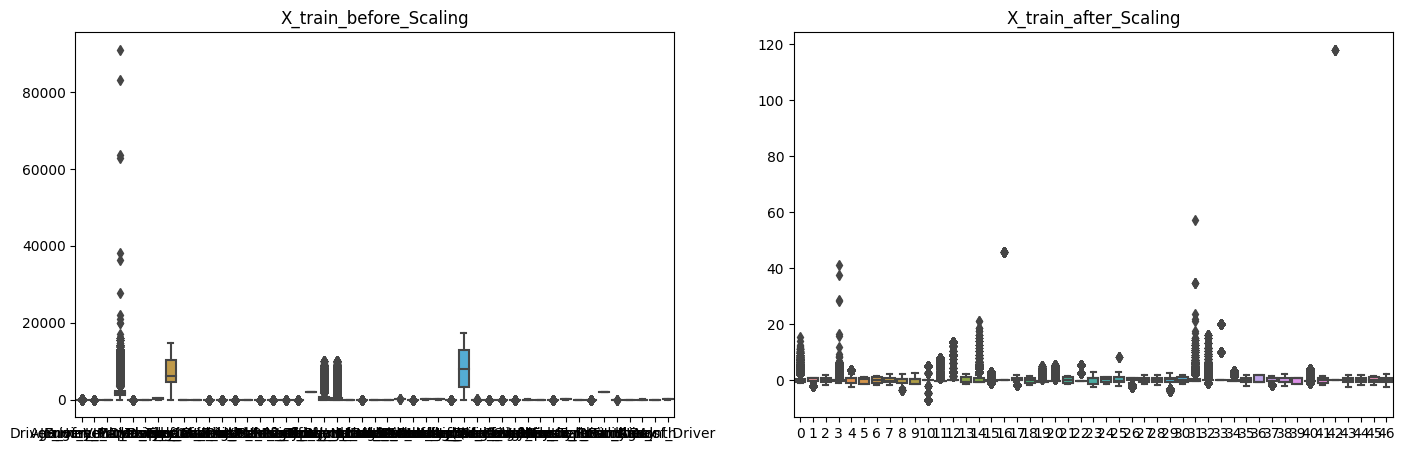

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(17,5))
plt.subplot(1,2,1)
sns.boxplot(data=X_train)
plt.title('X_train_before_Scaling')
plt.subplot(1,2,2)
sns.boxplot(data=X_train_after_Scaling)
plt.title('X_train_after_Scaling')

C:\Users\vraja\AppData\Local\Temp\ipykernel_17780\536871891.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0.5, 1.0, 'X_train_after_Scaling')

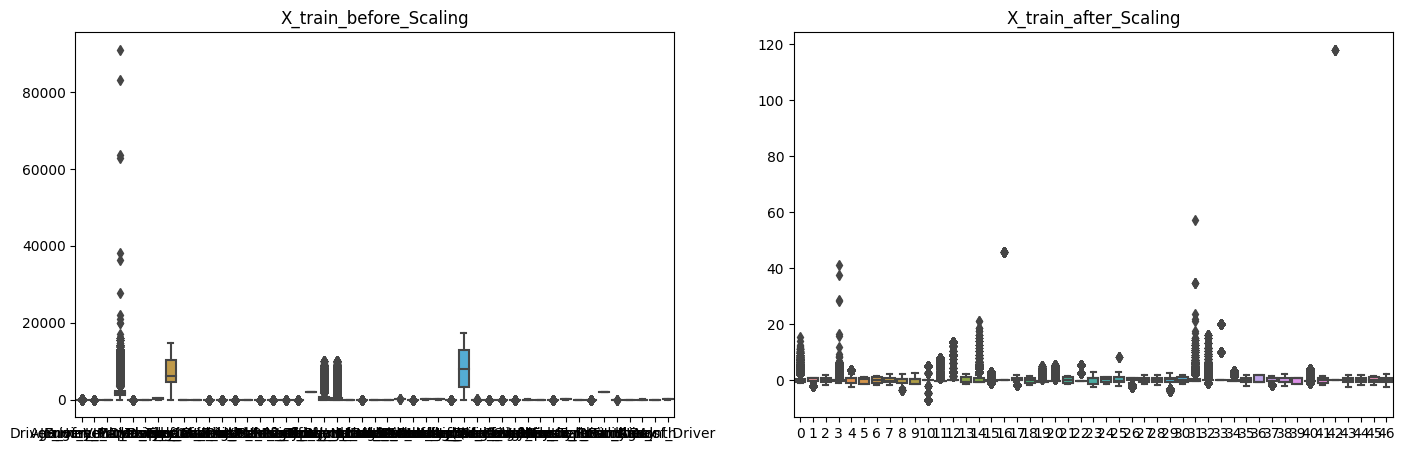

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(17,5))
plt.subplot(1,2,1)
sns.boxplot(data=X_train)
plt.title('X_train_before_Scaling')
plt.subplot(1,2,2)
sns.boxplot(data=X_train_after_Scaling)
plt.title('X_train_after_Scaling')

In [36]:
#next Scaling, PCA
df3['Accident_Severity'].value_counts()

0    89466
1    60619
2     6976
Name: Accident_Severity, dtype: int64

KNN Model Implementation

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import f1_score

In [38]:
accuracies = []
for i in range(1,50,2):
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train_after_Scaling, y_train)
    y_pred = clf.predict(X_test_after_Scaling)
    accuracy = f1_score(y_test, y_pred, average='weighted')
    print("K: ",i," ",accuracy)
    accuracies.append(accuracy)

K:  1   0.6971275718722334
K:  3   0.7119507635731034
K:  5   0.7244410414840466
K:  7   0.7272559255869656
K:  9   0.7284140408426998
K:  11   0.7298143029259891
K:  13   0.7290412988116537
K:  15   0.7289296901868199
K:  17   0.7296080268660153
K:  19   0.7292648705286702
K:  21   0.7299359836361622
K:  23   0.7286941651158888
K:  25   0.7287680939918038
K:  27   0.7289599745440065
K:  29   0.7282735161039466
K:  31   0.7292217220817333
K:  33   0.7291273304803103
K:  35   0.7298592773124264
K:  37   0.727659487031837
K:  39   0.7273356355369587
K:  41   0.7274282592212951
K:  43   0.7283117368451038
K:  45   0.7288644914044663
K:  47   0.7289342721707228
K:  49   0.7271688317035677


Text(0, 0.5, 'Accuracy')

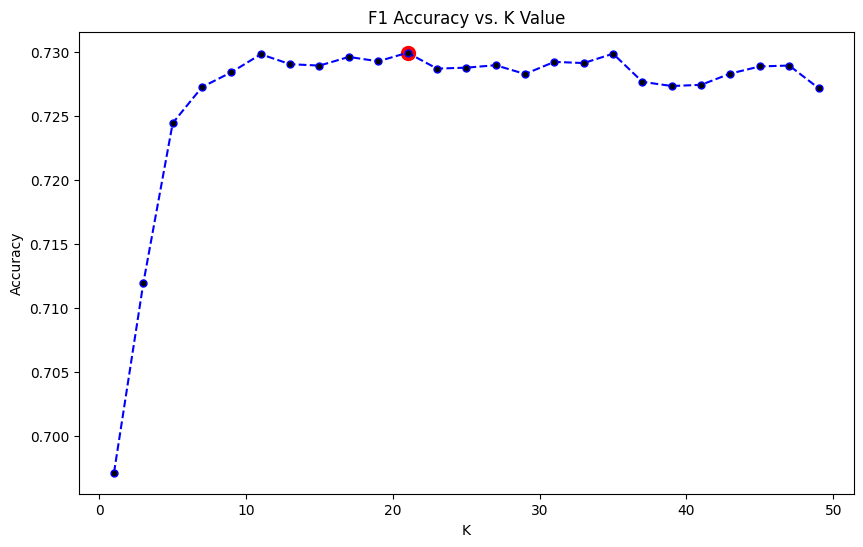

In [43]:
plt.figure(figsize=(10,6))
plt.plot(range(1,50,2), accuracies, color='blue', linestyle='dashed', marker='o', markerfacecolor='black', markersize=5)
plt.scatter(21, 0.7299359836361622, c='red', s=100)
plt.title('F1 Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

The above plot is the F1_score vs number of estimators.The F1 score becomes especially valuable when working on classification models in which your data set is imbalanced. You have seen that the F1 score combines precision and recall into a single metric. This makes it easy to use in grid search or automated optimization

Found above are all the accuracies for each value of the neighbors from 1 to 50. The maximum accuracy is 72.99% and is found at 21 neighbors.